<a href="https://colab.research.google.com/github/AlmightyAirsquid/EN466-Class-Content/blob/main/01_Data_Overview_and_Loading_DEED_GBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
# Check the current path
import os
print(os.getcwd())
# List the files in the current directory
!ls
# Clone the course repository from GitHub
!git clone https://github.com/hguangshuai/intro_ML_for_MSE
# Change into the repository directory
%cd intro_ML_for_MSE

/content/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE
01_Data_Overview_and_Loading.ipynb  Data     README.md	       Training
02_MLFF_example.ipynb		    LICENSE  requirements.txt  utils
Cloning into 'intro_ML_for_MSE'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 2), reused 27 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 775.65 KiB | 12.12 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE/intro_ML_for_MSE


# High-Entropy Alloy Catalyst Discovery: Data Overview and Loading

This notebook demonstrates machine learning approaches for predicting high-entropy alloy (HEA) properties.

## Dataset Overview

### Data Files
- **`lib5_FCC_CS_training.json`**: HEA compositions and target properties (DEED)
- **`Aflow_e_data.json`**: Elemental property database with atomic descriptors

### Target Variable
- **DEED**: Distance metric comparing HEA properties to platinum catalyst

### Features
- **24 features** generated from 6 elemental properties:
  - atomic_mass, atomic_number, atomic_radius, electronegativity, valence_electrons, work_function_Miedema
- **Statistical measures**: mean, variance, min, max for each property

## Analysis Pipeline
1. **Data Loading**: Load and examine dataset structure
2. **Feature Engineering**: Extract statistical features from elemental properties
3. **Data Analysis**: Correlation analysis and PCA visualization
4. **Clustering**: K-means clustering for sample classification
5. **Regression**: Random Forest for property prediction

Let's begin with data exploration and loading.


## 1. Data Structure Overview

Let's first examine the structure of our datasets to understand what we're working with.


In [80]:
# Load and examine the main training dataset
import json
import numpy as np
data_path = "Data/lib5_FCC_CS_training.json"

with open(data_path, 'r') as f:
    training_data = json.load(f)

print(f"Number of samples in training dataset: {len(training_data)}")
print(f"\nFirst sample structure:")
print(json.dumps(training_data[0], indent=2))


Number of samples in training dataset: 427

First sample structure:
{
  "Elements": [
    "Cr",
    "Cu",
    "Ti",
    "W",
    "Zn"
  ],
  "Composition": [
    "0.2",
    "0.2",
    "0.2",
    "0.2",
    "0.2"
  ],
  "EFA": 15.35842738123,
  "auid": "s4e:00635be4843abdc9",
  "DEED": 7.600625325603262,
  "wasserstein_dist_vs_pt": 4.350339031732405,
  "rmse_vs_pt": 0.6550503199125722,
  "mae_vs_pt": 0.4659998152265734,
  "cosine_similarity_vs_pt": 0.424899184251354,
  "fermi_energy": 5.83170443,
  "dist2hull": 0.265857
}


In [81]:
import json
# Load and examine the element property database
element_data_path = "Data/ele_data/Aflow_e_data.json"

with open(element_data_path, 'r') as f:
    element_data = json.load(f)

print(f"Number of elements in database: {len(element_data)}")
print(f"\nElement names: {list(element_data.keys())[:10]}...")

# Examine properties for a sample element (e.g., Fe)
sample_element = 'Fe'
if sample_element in element_data:
    print(f"\nProperties for {sample_element}:")
    fe_props = element_data[sample_element]
    for prop, value in list(fe_props.items())[:10]:
        print(f"  {prop}: {value}")
    print(f"  ... and {len(fe_props) - 10} more properties")


Number of elements in database: 104

Element names: ['AAA_notes', 'Ac', 'Ag', 'Al', 'Am', 'Ar', 'As', 'At', 'Au', 'B']...

Properties for Fe:
  Mendeleev_number: 61.0
  atomic_mass: 55.845
  atomic_number: 26.0
  c6: 482.0
  c6_gb: 548.0
  chemical_scale_Pettifor: 0.99
  conductivity_thermal: 79.0
  critical_pressure: None
  critical_temperature_PT: None
  density: 7.874
  ... and 41 more properties


## 2. Data Loading and Processing

Now let's demonstrate how to load and process the data using the provided utilities.


In [82]:
# Import the data utilities
from utils.data_util import ele_df, json_loader

# Define the properties we want to use for feature extraction
prop_list = [
    "atomic_mass",
    "atomic_number",
    "conductivity_thermal",
    "density_PT",
    "electron_affinity_PT",
    "electronegativity_Allen"
]


In [83]:

# 2. Create element property dataframe
print("\nCreating element property dataframe...")
ele_DF = ele_df(prop_list=prop_list,
                normalize='quantile')

print(f"Element dataframe shape: {ele_DF.shape}")
print(f"Number of properties (rows): {ele_DF.shape[0]}")
print(f"Number of elements (columns): {ele_DF.shape[1]}")



Creating element property dataframe...

[Missing Value Fill Report]
Number of elements with filled values: 19
Element dataframe shape: (6, 103)
Number of properties (rows): 6
Number of elements (columns): 103


In [84]:

# 3. Use json_loader to load data and extract features
data_path = 'Data/lib5_FCC_CS_training.json'
print("Loading data with json_loader...")
data_loader = json_loader(str(data_path), df_data=ele_DF)

# Load features and targets
X, y, elements = data_loader.load_data_nocomp(
    target_key='DEED',
    split=False
)

print(f"Feature matrix shape: {np.array(X).shape}")
print(f"Target vector shape: {np.array(y).shape}")
print(f"Number of samples: {len(elements)}")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
print(y)
print(f"\nFeature matrix (X): {X.shape}")
print(f"Target vector (y): {y.shape}")
print(f"Target statistics:")
print(f"  Mean: {np.mean(y):.3f}")
print(f"  Std: {np.std(y):.3f}")
print(f"  Min: {np.min(y):.3f}")
print(f"  Max: {np.max(y):.3f}")


Loading data with json_loader...
Feature matrix shape: (427, 24)
Target vector shape: (427,)
Number of samples: 427
[ 7.60062533 11.19437746  9.11138492 11.13010056  7.9058534   9.82629338
  9.78651844 13.95960983 12.92642918 10.0246982   8.11654148  9.41620411
 10.26617715  9.9042739   8.60851078  8.86431547 11.16564684  9.29377242
 11.03644191 10.98306778 12.64603794  9.24459795 10.4889052  10.00393597
  7.8279501   9.38180303 10.50520849  8.69463471 11.86145118 10.28247413
 10.0204029   8.96329283  7.65699799 14.86300983  9.8148355   9.25823147
  8.193944   10.55145857 13.43865308  8.44776026  9.38237122 14.63762096
 11.9397866  10.17888877  8.80731777  8.93128274  8.42135061 12.19775373
 10.79898307 10.21945676 12.53873471 10.83608196  9.55608851 11.08491081
 11.82232287  9.34696877  9.76632643  8.61357016  9.30624875  8.25721525
  9.51874096  9.25063685 11.19016478  8.36005922  9.59769423 11.61750474
 13.98592104  8.94535161 10.99947099  7.82618959  9.30257581 12.38562835
  8.9855

In [85]:
# Remove samples with NaN values in target
print("Checking for NaN values...")
nan_mask = ~np.isnan(y)
original_count = len(y)
X_clean = X[nan_mask]
y_clean = y[nan_mask]
elements_clean = [elements[i] for i in range(len(elements)) if nan_mask[i]]

print(f"Removed {original_count - len(y_clean)} samples with NaN target values")
print(f"Remaining samples: {len(y_clean)}")

print(f"\nAfter cleaning:")
print(f"Feature matrix (X): {X_clean.shape}")
print(f"Target vector (y): {y_clean.shape}")
print(f"Target statistics:")
print(f"  Mean: {np.mean(y_clean):.3f}")
print(f"  Std: {np.std(y_clean):.3f}")
print(f"  Min: {np.min(y_clean):.3f}")
print(f"  Max: {np.max(y_clean):.3f}")

# Update variables for further use
X = X_clean
y = y_clean
elements = elements_clean


Checking for NaN values...
Removed 0 samples with NaN target values
Remaining samples: 427

After cleaning:
Feature matrix (X): (427, 24)
Target vector (y): (427,)
Target statistics:
  Mean: 10.251
  Std: 1.940
  Min: 7.192
  Max: 20.460


Target Distribution Analysis
Total samples: 427


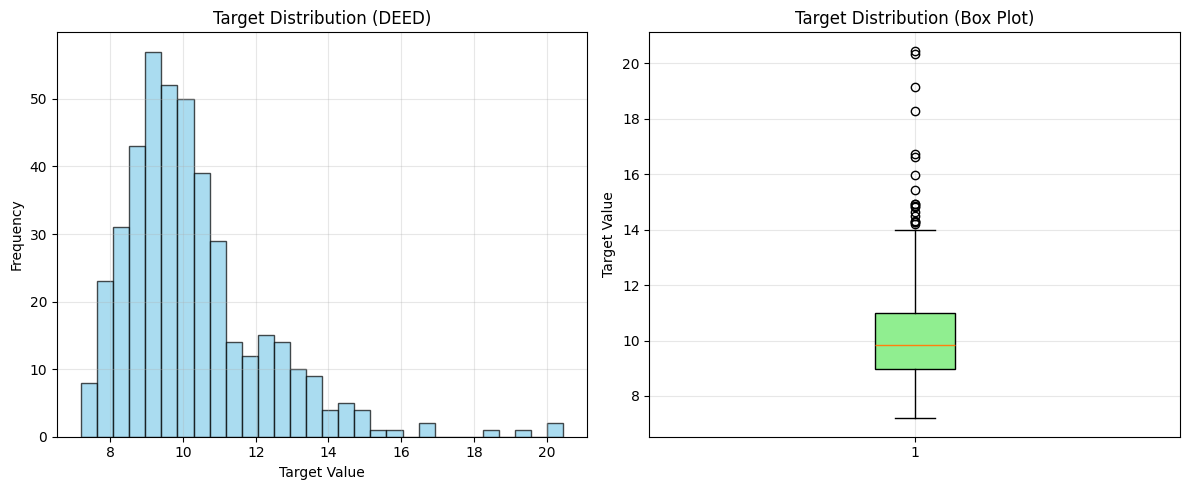


Target Statistics:
  Mean: 10.251
  Median: 9.846
  Std: 1.940
  Min: 7.192
  Max: 20.460


In [86]:
# Simplified Pre-analysis: Label distribution only
import matplotlib.pyplot as plt

print("Target Distribution Analysis")
print(f"Total samples: {len(y)}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Histogram
axes[0].hist(y, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0].set_title('Target Distribution (DEED)')
axes[0].set_xlabel('Target Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# 2. Box plot
axes[1].boxplot(y, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axes[1].set_title('Target Distribution (Box Plot)')
axes[1].set_ylabel('Target Value')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nTarget Statistics:")
print(f"  Mean: {np.mean(y):.3f}")
print(f"  Median: {np.median(y):.3f}")
print(f"  Std: {np.std(y):.3f}")
print(f"  Min: {np.min(y):.3f}")
print(f"  Max: {np.max(y):.3f}")


Feature Analysis: Correlation Coefficient Map
Feature matrix shape: (427, 24)
Number of properties in prop_list: 6
Expected feature names: 24
Actual features in X: 24
✓ Feature names match actual features!


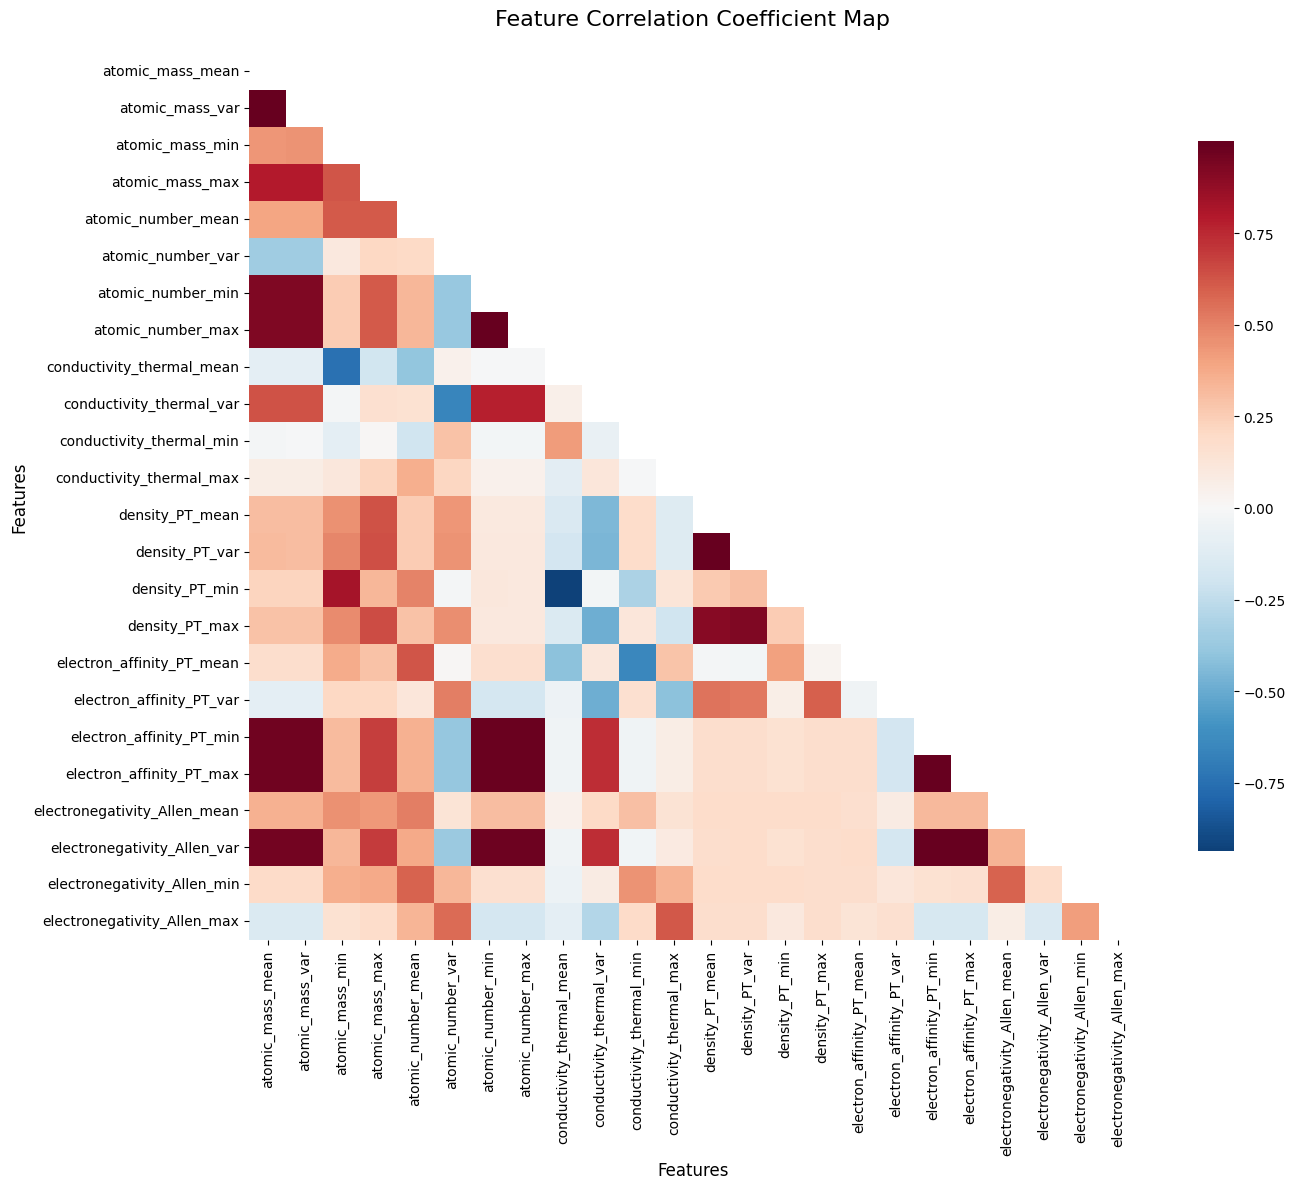


Correlation Analysis:
Total features: 24

Highly correlated feature pairs (|correlation| > 0.8):
  electron_affinity_PT_min <-> electron_affinity_PT_max: 1.000
  atomic_number_min <-> atomic_number_max: 1.000
  atomic_mass_mean <-> atomic_mass_var: 1.000
  electron_affinity_PT_min <-> electronegativity_Allen_var: 0.995
  electron_affinity_PT_max <-> electronegativity_Allen_var: 0.995
  density_PT_mean <-> density_PT_var: 0.989
  atomic_number_max <-> electron_affinity_PT_max: 0.984
  atomic_number_min <-> electron_affinity_PT_max: 0.984
  atomic_number_max <-> electron_affinity_PT_min: 0.984
  atomic_number_min <-> electron_affinity_PT_min: 0.984

Low variance features (variance < 0.01): 18
Low variance feature names:
  atomic_mass_mean: 0.002346
  atomic_mass_var: 0.002349
  atomic_mass_min: 0.006457
  atomic_mass_max: 0.003711
  atomic_number_var: 0.003236
  atomic_number_min: 0.000265
  atomic_number_max: 0.000266
  conductivity_thermal_mean: 0.000734
  conductivity_thermal_var: 0.

In [87]:
# Feature Analysis: Correlation Coefficient Map
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Feature Analysis: Correlation Coefficient Map")
print(f"Feature matrix shape: {X.shape}")
print(f"Number of properties in prop_list: {len(prop_list)}")

# Create feature names for correlation analysis
# Based on the actual implementation in data_util.py, there are 4 statistical features:
# mean, var, min, max (delta and weighted_avg are commented out)
feature_names = []
for prop in prop_list:
    feature_names.extend([f"{prop}_mean", f"{prop}_var", f"{prop}_min", f"{prop}_max"])

print(f"Expected feature names: {len(feature_names)}")
print(f"Actual features in X: {X.shape[1]}")

# Verify the feature count matches
if len(feature_names) == X.shape[1]:
    print("✓ Feature names match actual features!")
else:
    print(f"✗ Mismatch: Expected {len(feature_names)}, got {X.shape[1]}")

# Create DataFrame for correlation analysis
feature_df = pd.DataFrame(X, columns=feature_names)

# Calculate correlation matrix
correlation_matrix = feature_df.corr()

# Create visualization
plt.figure(figsize=(15, 12))

# Plot correlation heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=False,  # Don't show correlation values (too many)
            cmap='RdBu_r',
            center=0,
            square=True,
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Coefficient Map', fontsize=16, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze high correlations
print(f"\nCorrelation Analysis:")
print(f"Total features: {len(feature_names)}")

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"\nHighly correlated feature pairs (|correlation| > 0.8):")
if high_corr_pairs:
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("  No highly correlated pairs found")

# Feature variance analysis
feature_vars = np.var(X, axis=0)
low_var_features = np.where(feature_vars < 0.01)[0]  # Low variance threshold
print(f"\nLow variance features (variance < 0.01): {len(low_var_features)}")
if len(low_var_features) > 0:
    print("Low variance feature names:")
    for idx in low_var_features[:10]:  # Show first 10
        print(f"  {feature_names[idx]}: {feature_vars[idx]:.6f}")


## Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving the most important information.

### Key Concepts:
- **Principal Components**: New orthogonal axes that capture maximum variance
- **Explained Variance**: How much of the original variance each component captures
- **Feature Loadings**: How much each original feature contributes to each component

### Why Use PCA:
- **Dimensionality Reduction**: Reduce from 24 features to fewer components
- **Remove Multicollinearity**: Eliminate correlated features
- **Visualization**: Project high-dimensional data to 2D/3D
- **Noise Reduction**: Focus on signal rather than noise

### ML Applications:
- **Feature Engineering**: Use PCA components as new features
- **Preprocessing**: Reduce overfitting in high-dimensional data
- **Visualization**: Understand data structure before modeling
- **Model Performance**: Often improves performance with fewer features


Principal Component Analysis (PCA)
Original feature matrix shape: (427, 24)
Scaled feature matrix shape: (427, 24)

PCA Results:
Number of components: 24
First 5 components explain: [0.3735865  0.59020258 0.71668786 0.81731104 0.86947756]
Components needed for 95% variance: 8


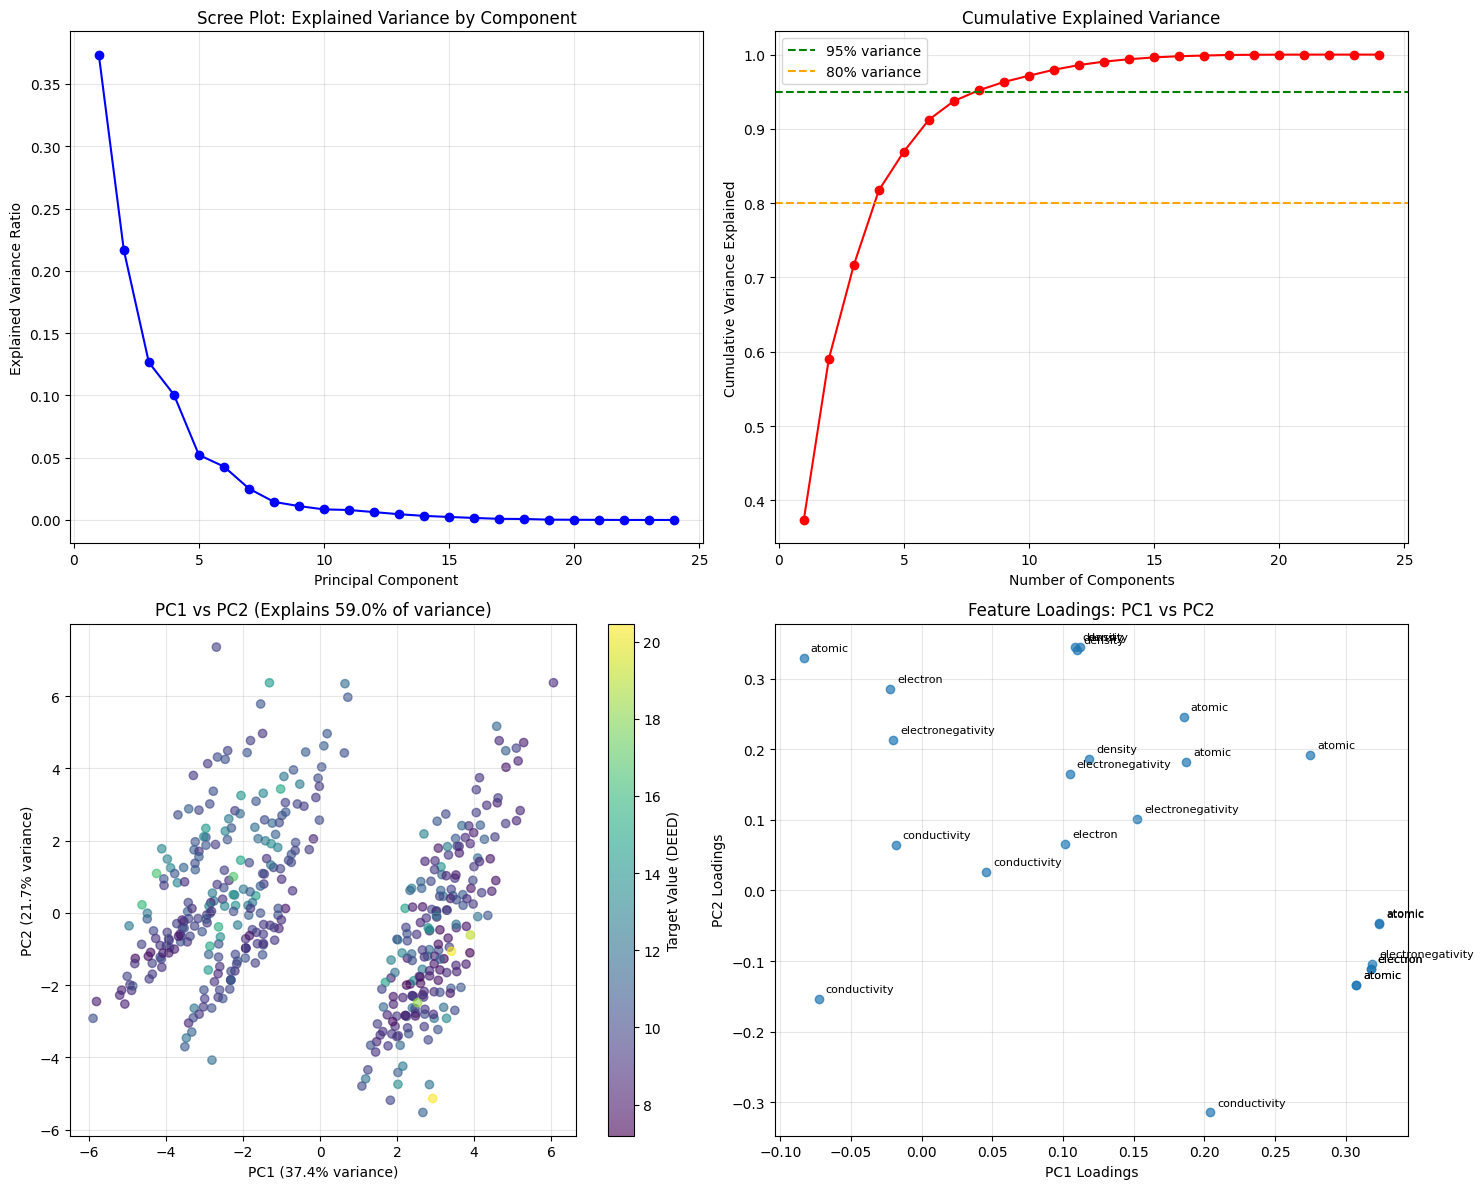


Detailed PCA Analysis:
PC1 explains 37.4% of variance
PC2 explains 21.7% of variance
PC1 + PC2 explain 59.0% of variance

Top 5 features contributing to PC1:
  atomic_mass_var: 0.324
  atomic_mass_mean: 0.324
  electronegativity_Allen_var: 0.319
  electron_affinity_PT_min: 0.318
  electron_affinity_PT_max: 0.318

Top 5 features contributing to PC2:
  density_PT_var: 0.345
  density_PT_max: 0.345
  density_PT_mean: 0.341
  atomic_number_var: 0.329
  conductivity_thermal_var: -0.315

PCA analysis complete! Results saved in 'pca_results' dictionary.


In [88]:
# Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

print("Principal Component Analysis (PCA)")
print(f"Original feature matrix shape: {X.shape}")

# Standardize features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Scaled feature matrix shape: {X_scaled.shape}")

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\nPCA Results:")
print(f"Number of components: {len(explained_variance_ratio)}")
print(f"First 5 components explain: {cumulative_variance[:5]}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scree plot
axes[0, 0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
axes[0, 0].set_title('Scree Plot: Explained Variance by Component')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True, alpha=0.3)

# 2. Cumulative variance plot
axes[0, 1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[0, 1].axhline(y=0.95, color='g', linestyle='--', label='95% variance')
axes[0, 1].axhline(y=0.80, color='orange', linestyle='--', label='80% variance')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Variance Explained')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. PC1 vs PC2 scatter plot
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c=y, cmap='viridis')
axes[1, 0].set_title(f'PC1 vs PC2 (Explains {cumulative_variance[1]:.1%} of variance)')
axes[1, 0].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
axes[1, 0].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
axes[1, 0].grid(True, alpha=0.3)

# Add colorbar for target values
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Target Value (DEED)')

# 4. Feature loadings for PC1 and PC2
loadings = pca.components_[:2].T  # First 2 components
feature_names_short = [name.split('_')[0] for name in feature_names]  # Short names for readability

axes[1, 1].scatter(loadings[:, 0], loadings[:, 1], alpha=0.7)
axes[1, 1].set_title('Feature Loadings: PC1 vs PC2')
axes[1, 1].set_xlabel('PC1 Loadings')
axes[1, 1].set_ylabel('PC2 Loadings')
axes[1, 1].grid(True, alpha=0.3)

# Add feature labels
for i, name in enumerate(feature_names_short):
    axes[1, 1].annotate(name, (loadings[i, 0], loadings[i, 1]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Detailed analysis
print(f"\nDetailed PCA Analysis:")
print(f"PC1 explains {explained_variance_ratio[0]:.1%} of variance")
print(f"PC2 explains {explained_variance_ratio[1]:.1%} of variance")
print(f"PC1 + PC2 explain {cumulative_variance[1]:.1%} of variance")

# Top contributing features to PC1 and PC2
pc1_loadings = pca.components_[0]
pc2_loadings = pca.components_[1]

print(f"\nTop 5 features contributing to PC1:")
pc1_indices = np.argsort(np.abs(pc1_loadings))[-5:][::-1]
for idx in pc1_indices:
    print(f"  {feature_names[idx]}: {pc1_loadings[idx]:.3f}")

print(f"\nTop 5 features contributing to PC2:")
pc2_indices = np.argsort(np.abs(pc2_loadings))[-5:][::-1]
for idx in pc2_indices:
    print(f"  {feature_names[idx]}: {pc2_loadings[idx]:.3f}")

# Save PCA results for further analysis
pca_results = {
    'X_pca': X_pca,
    'explained_variance_ratio': explained_variance_ratio,
    'cumulative_variance': cumulative_variance,
    'components': pca.components_,
    'feature_names': feature_names
}

print(f"\nPCA analysis complete! Results saved in 'pca_results' dictionary.")


K-means Clustering Analysis
Dataset shape: (427, 24), Target shape: (427,)
Median target value: 9.846
High target samples (>median): 213
Low target samples (≤median): 214

Train set: 298 samples
Test set: 129 samples

Training K-means clustering...
Converged after 3 iterations
Train cluster distribution: [132 166]
Test cluster distribution: [62 67]


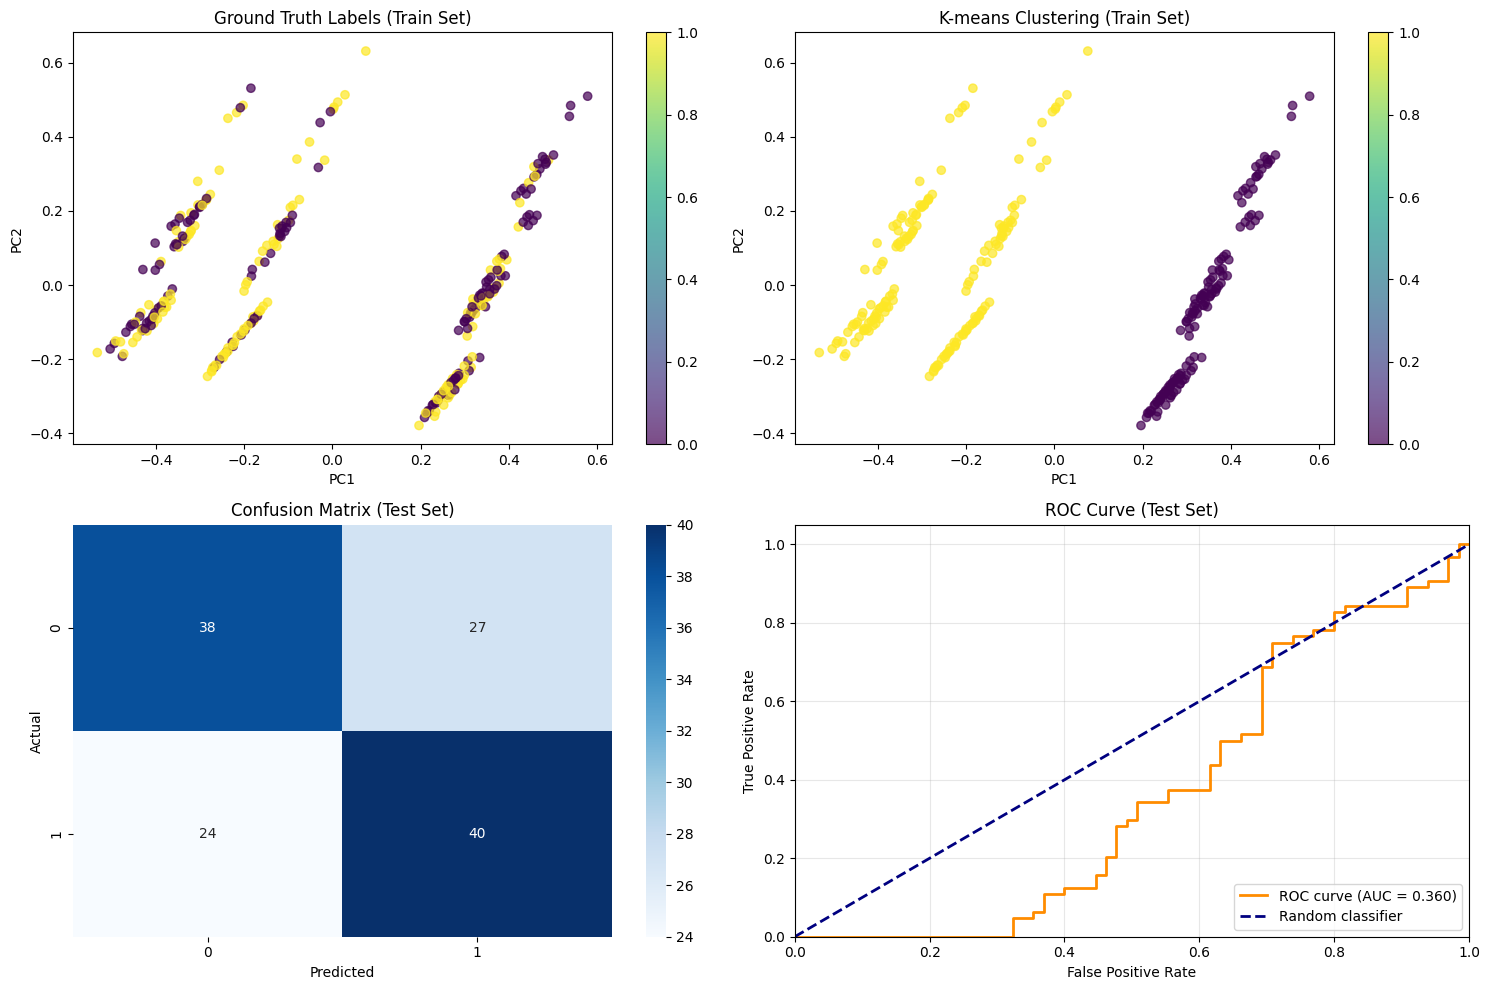


Performance Metrics:
Train Accuracy: 0.574
Test Accuracy: 0.605
Test AUC: 0.360

Test Classification Report:
              precision    recall  f1-score   support

  Low Target       0.61      0.58      0.60        65
 High Target       0.60      0.62      0.61        64

    accuracy                           0.60       129
   macro avg       0.60      0.60      0.60       129
weighted avg       0.61      0.60      0.60       129


Cluster Analysis:
Cluster 0:
  Train samples: 132 (mean target: 10.009)
  Test samples: 62 (mean target: 9.972)
Cluster 1:
  Train samples: 166 (mean target: 10.438)
  Test samples: 67 (mean target: 10.523)

K-means clustering analysis complete!


In [89]:
# K-means Clustering Implementation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
import seaborn as sns

print("K-means Clustering Analysis")
print(f"Dataset shape: {X.shape}, Target shape: {y.shape}")

# 1. Data Preparation
# Create binary labels based on median target value
median_target = np.median(y)
binary_labels = (y > median_target).astype(int)
print(f"Median target value: {median_target:.3f}")
print(f"High target samples (>median): {np.sum(binary_labels)}")
print(f"Low target samples (≤median): {len(binary_labels) - np.sum(binary_labels)}")

# Train-test split
X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(
    X, y, binary_labels, test_size=0.3, random_state=42, stratify=binary_labels
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 2. Hand-crafted K-means Implementation
class KMeansClustering:
    def __init__(self, k=2, max_iters=100, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids using k-means++ method"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Choose first centroid randomly
        centroids = [X[np.random.choice(n_samples)]]

        # Choose remaining centroids
        for _ in range(self.k - 1):
            distances = np.array([min([np.linalg.norm(x - c)**2 for c in centroids]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_probabilities = probabilities.cumsum()
            r = np.random.rand()

            for i, p in enumerate(cumulative_probabilities):
                if r < p:
                    centroids.append(X[i])
                    break

        return np.array(centroids)

    def _assign_clusters(self, X, centroids):
        """Assign each point to the closest centroid"""
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        """Update centroids based on current cluster assignments"""
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = cluster_points.mean(axis=0)
        return centroids

    def fit(self, X):
        """Fit K-means clustering to data"""
        # Initialize centroids
        self.centroids = self._initialize_centroids(X)

        # Iterate until convergence
        for iteration in range(self.max_iters):
            # Assign points to clusters
            old_labels = self.labels
            self.labels = self._assign_clusters(X, self.centroids)

            # Check for convergence
            if old_labels is not None and np.array_equal(old_labels, self.labels):
                print(f"Converged after {iteration + 1} iterations")
                break

            # Update centroids
            self.centroids = self._update_centroids(X, self.labels)

        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        return self._assign_clusters(X, self.centroids)

# 3. Train K-means model
print("\nTraining K-means clustering...")
kmeans = KMeansClustering(k=2, max_iters=100, random_state=42)
kmeans.fit(X_train)

# Predict on train and test sets
train_pred = kmeans.predict(X_train)
test_pred = kmeans.predict(X_test)

print(f"Train cluster distribution: {np.bincount(train_pred)}")
print(f"Test cluster distribution: {np.bincount(test_pred)}")

# 4. Create PCA for visualization only (not used in clustering)
pca_viz = PCA(n_components=2)
X_train_pca = pca_viz.fit_transform(X_train)
X_test_pca = pca_viz.transform(X_test)

# 5. Evaluation and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Ground truth labels (Train set) - Keep this one
scatter1 = axes[0, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels_train, cmap='viridis', alpha=0.7)
axes[0, 0].set_title('Ground Truth Labels (Train Set)')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
plt.colorbar(scatter1, ax=axes[0, 0])

# Plot 2: K-means clustering results (Train set)
scatter2 = axes[0, 1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_pred, cmap='viridis', alpha=0.7)
axes[0, 1].set_title('K-means Clustering (Train Set)')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[0, 1])

# Plot 3: Confusion Matrix (Test)
cm_test = confusion_matrix(labels_test, test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix (Test Set)')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Plot 4: ROC Curve
# Calculate distances to centroids for ROC curve
def calculate_distances_to_centroids(X, centroids):
    """Calculate distances to each centroid"""
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return distances

# Get distances for test set
test_distances = calculate_distances_to_centroids(X_test, kmeans.centroids)
# Use distance to cluster 1 as probability (assuming cluster 1 is "high target")
test_prob = test_distances[1] / (test_distances[0] + test_distances[1])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels_test, test_prob)
roc_auc = auc(fpr, tpr)

axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve (Test Set)')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Performance Metrics
print(f"\nPerformance Metrics:")
print(f"Train Accuracy: {accuracy_score(labels_train, train_pred):.3f}")
print(f"Test Accuracy: {accuracy_score(labels_test, test_pred):.3f}")
print(f"Test AUC: {roc_auc:.3f}")

print(f"\nTest Classification Report:")
print(classification_report(labels_test, test_pred, target_names=['Low Target', 'High Target']))

# 7. Cluster Analysis
print(f"\nCluster Analysis:")
for i in range(2):
    train_cluster_mask = train_pred == i
    test_cluster_mask = test_pred == i

    train_mean_target = y_train[train_cluster_mask].mean()
    test_mean_target = y_test[test_cluster_mask].mean()

    print(f"Cluster {i}:")
    print(f"  Train samples: {np.sum(train_cluster_mask)} (mean target: {train_mean_target:.3f})")
    print(f"  Test samples: {np.sum(test_cluster_mask)} (mean target: {test_mean_target:.3f})")

print(f"\nK-means clustering analysis complete!")


## Classification Metrics and Confusion Matrix

### Confusion Matrix
A confusion matrix is a table that describes the performance of a classification model by showing the actual vs predicted classifications.

For binary classification:
```
                 Predicted
                0    1
Actual    0   TN   FP
          1   FN   TP
```

Where:
- **TP (True Positive)**: Correctly predicted positive class
- **TN (True Negative)**: Correctly predicted negative class  
- **FP (False Positive)**: Incorrectly predicted positive class (Type I error)
- **FN (False Negative)**: Incorrectly predicted negative class (Type II error)

### Key Classification Metrics

#### 1. **Accuracy**
- **Formula**: `(TP + TN) / (TP + TN + FP + FN)`
- **Interpretation**: Overall correctness of predictions
- **Range**: [0, 1], higher is better

#### 2. **Precision**
- **Formula**: `TP / (TP + FP)`
- **Interpretation**: Of all positive predictions, how many were correct?
- **Range**: [0, 1], higher is better
- **Use case**: Important when false positives are costly

#### 3. **Recall (Sensitivity)**
- **Formula**: `TP / (TP + FN)`
- **Interpretation**: Of all actual positives, how many did we catch?
- **Range**: [0, 1], higher is better
- **Use case**: Important when false negatives are costly

#### 4. **Specificity**
- **Formula**: `TN / (TN + FP)`
- **Interpretation**: Of all actual negatives, how many did we correctly identify?
- **Range**: [0, 1], higher is better

#### 5. **F1-Score**
- **Formula**: `2 × (Precision × Recall) / (Precision + Recall)`
- **Interpretation**: Harmonic mean of precision and recall
- **Range**: [0, 1], higher is better
- **Use case**: Balance between precision and recall

#### 6. **Fβ-Score**
- **Formula**: `(1 + β²) × (Precision × Recall) / (β² × Precision + Recall)`
- **Interpretation**: Weighted harmonic mean
- **β > 1**: Emphasizes recall more
- **β < 1**: Emphasizes precision more

#### 7. **ROC-AUC**
- **Formula**: Area under ROC curve
- **Interpretation**: Probability that classifier ranks random positive higher than random negative
- **Range**: [0, 1], higher is better
- **Perfect**: AUC = 1.0, Random: AUC = 0.5

### When to Use Each Metric

- **Accuracy**: Balanced dataset, equal cost of errors
- **Precision**: False positives are expensive (e.g., spam detection)
- **Recall**: False negatives are dangerous (e.g., medical diagnosis)
- **F1-Score**: Imbalanced dataset, need balance
- **ROC-AUC**: Ranking/Probability tasks, imbalanced data


In [90]:
# Hand-crafted Classification Metrics Calculator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def calculate_confusion_matrix(y_true, y_pred):
    """
    Calculate confusion matrix from scratch
    """
    # Get unique classes
    classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(classes)

    # Initialize confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)

    # Fill confusion matrix
    for i in range(len(y_true)):
        true_idx = np.where(classes == y_true[i])[0][0]
        pred_idx = np.where(classes == y_pred[i])[0][0]
        cm[true_idx, pred_idx] += 1

    return cm, classes

def calculate_metrics_from_scratch(y_true, y_pred):
    """
    Calculate all classification metrics from scratch using confusion matrix
    """
    # Calculate confusion matrix
    cm, classes = calculate_confusion_matrix(y_true, y_pred)

    # For binary classification, extract TP, TN, FP, FN
    if len(classes) == 2:
        tn, fp, fn, tp = cm.ravel()

        # Calculate metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # F-beta scores
        f2_score = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if (2**2 * precision + recall) > 0 else 0
        f0_5_score = (1 + 0.5**2) * (precision * recall) / (0.5**2 * precision + recall) if (0.5**2 * precision + recall) > 0 else 0

        metrics = {
            'confusion_matrix': cm,
            'classes': classes,
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1_score,
            'f2_score': f2_score,
            'f0_5_score': f0_5_score
        }

        return metrics
    else:
        # For multiclass, calculate macro averages
        precision_per_class = []
        recall_per_class = []

        for i in range(len(classes)):
            tp = cm[i, i]
            fp = cm[:, i].sum() - tp
            fn = cm[i, :].sum() - tp

            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0

            precision_per_class.append(prec)
            recall_per_class.append(rec)

        macro_precision = np.mean(precision_per_class)
        macro_recall = np.mean(recall_per_class)
        macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0

        metrics = {
            'confusion_matrix': cm,
            'classes': classes,
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1
        }

        return metrics

def calculate_roc_auc_from_scratch(y_true, y_scores):
    """
    Calculate ROC curve and AUC from scratch
    """
    # Sort by scores in descending order
    sorted_indices = np.argsort(y_scores)[::-1]
    sorted_labels = y_true[sorted_indices]
    sorted_scores = y_scores[sorted_indices]

    # Get unique thresholds
    thresholds = np.unique(sorted_scores)
    thresholds = np.append(thresholds, float('inf'))

    tpr_values = []
    fpr_values = []

    # Count total positives and negatives
    total_positives = np.sum(y_true == 1)
    total_negatives = np.sum(y_true == 0)

    for threshold in thresholds:
        # Predictions based on threshold
        predictions = (sorted_scores >= threshold).astype(int)

        # Calculate TP, FP, TN, FN
        tp = np.sum((predictions == 1) & (sorted_labels == 1))
        fp = np.sum((predictions == 1) & (sorted_labels == 0))
        tn = np.sum((predictions == 0) & (sorted_labels == 0))
        fn = np.sum((predictions == 0) & (sorted_labels == 1))

        # Calculate TPR and FPR
        tpr = tp / total_positives if total_positives > 0 else 0
        fpr = fp / total_negatives if total_negatives > 0 else 0

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Calculate AUC using trapezoidal rule
    auc_score = 0
    for i in range(1, len(fpr_values)):
        auc_score += (fpr_values[i] - fpr_values[i-1]) * (tpr_values[i] + tpr_values[i-1]) / 2

    return fpr_values, tpr_values, auc_score

# Test with our K-means results
print("Hand-crafted Classification Metrics Calculator")
print("=" * 50)

# Use test set results from K-means
y_true_test = labels_test
y_pred_test = test_pred

# Calculate metrics from scratch
metrics = calculate_metrics_from_scratch(y_true_test, y_pred_test)

print("Confusion Matrix:")
print(metrics['confusion_matrix'])
print(f"Classes: {metrics['classes']}")

print(f"\nDetailed Metrics:")
print(f"TP: {metrics['TP']}, TN: {metrics['TN']}, FP: {metrics['FP']}, FN: {metrics['FN']}")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Specificity: {metrics['specificity']:.4f}")
print(f"F1-Score: {metrics['f1_score']:.4f}")
print(f"F2-Score: {metrics['f2_score']:.4f}")
print(f"F0.5-Score: {metrics['f0_5_score']:.4f}")

# Calculate ROC-AUC from scratch
print(f"\nROC-AUC Calculation:")
# Create probability scores based on distances to centroids
test_distances = calculate_distances_to_centroids(X_test, kmeans.centroids)
y_scores = test_distances[1] / (test_distances[0] + test_distances[1])


Hand-crafted Classification Metrics Calculator
Confusion Matrix:
[[38 27]
 [24 40]]
Classes: [0 1]

Detailed Metrics:
TP: 40, TN: 38, FP: 27, FN: 24
Accuracy: 0.6047
Precision: 0.5970
Recall: 0.6250
Specificity: 0.5846
F1-Score: 0.6107
F2-Score: 0.6192
F0.5-Score: 0.6024

ROC-AUC Calculation:


## Random Forest Regression

### What is Random Forest?
Random Forest is an ensemble learning method that combines multiple decision trees to make more accurate predictions. It's particularly effective for regression tasks and handles both linear and non-linear relationships well.

### Key Concepts:

#### 1. **Bootstrap Aggregating (Bagging)**
- **Bootstrap Sampling**: Each tree is trained on a random subset of data (with replacement)
- **Aggregation**: Final prediction is the average of all tree predictions
- **Reduces Overfitting**: Individual trees may overfit, but ensemble reduces variance

#### 2. **Random Feature Selection**
- **Feature Randomness**: At each split, only a random subset of features is considered
- **DDEEDult**: √n_features for regression, √n_features for classification
- **Benefits**: Reduces correlation between trees, improves generalization

#### 3. **Decision Tree Structure**
- **Splitting Criterion**: Mean Squared Error (MSE) for regression
- **Stopping Criteria**: Max depth, min samples per leaf, min samples to split
- **Leaf Prediction**: Average of target values in the leaf

### Advantages:
- **High Accuracy**: Often outperforms single decision trees
- **Robust**: Handles outliers and missing values well
- **Feature Importance**: Provides feature importance scores
- **No Overfitting**: Built-in regularization through bagging
- **Fast Training**: Parallelizable, efficient implementation

### Hyperparameters:
- **n_estimators**: Number of trees (more = better, but slower)
- **max_depth**: Maximum depth of trees
- **min_samples_split**: Minimum samples required to split a node
- **min_samples_leaf**: Minimum samples in a leaf node
- **max_features**: Number of features to consider at each split
- **random_state**: For reproducibility

### Regression Metrics:

#### 1. **R² Score (Coefficient of Determination)**
- **Formula**: `1 - (SS_res / SS_tot)`
- **Range**: (-∞, 1], 1 = perfect, 0 = no better than mean
- **Interpretation**: Proportion of variance explained

#### 2. **Mean Absolute Error (MAE)**
- **Formula**: `(1/n) × Σ|y_true - y_pred|`
- **Range**: [0, ∞), lower is better
- **Interpretation**: Average absolute difference

#### 3. **Mean Squared Error (MSE)**
- **Formula**: `(1/n) × Σ(y_true - y_pred)²`
- **Range**: [0, ∞), lower is better
- **Interpretation**: Average squared difference

#### 4. **Root Mean Squared Error (RMSE)**
- **Formula**: `√MSE`
- **Range**: [0, ∞), lower is better
- **Interpretation**: Standard deviation of residuals

#### 5. **Mean Absolute Percentage Error (MAPE)**
- **Formula**: `(100/n) × Σ|y_true - y_pred|/|y_true|`
- **Range**: [0, ∞), lower is better
- **Interpretation**: Average percentage error

### When to Use Random Forest:
- **Tabular Data**: Excellent for structured data
- **Mixed Data Types**: Handles both numerical and categorical features
- **Feature Selection**: Need to understand feature importance
- **Robust Predictions**: Want stable, reliable predictions
- **Baseline Model**: Good starting point for many problems


Efficient Random Forest Regression Analysis
1. Data Preparation
Dataset shape: (427, 24), Target shape: (427,)
Train set: 341 samples
Test set: 86 samples
Target statistics:
  Train - Mean: 10.312, Std: 1.973
  Test - Mean: 10.012, Std: 1.781

2. Random Forest Model Training
Training completed in 0.26 seconds
Number of trees: 100
Max depth: 15

3. Making Predictions
Predictions completed in 0.01 seconds

Train Set Metrics:
  R² Score: 0.9999
  MAE: 0.0050
  MSE: 0.0003
  RMSE: 0.0171
  MAPE: 0.04%
  Mean Residual: -0.0000
  Std Residual: 0.0171
  Explained Variance: 0.9999

Test Set Metrics:
  R² Score: 0.6349
  MAE: 0.8065
  MSE: 1.1585
  RMSE: 1.0763
  MAPE: 7.78%
  Mean Residual: -0.0188
  Std Residual: 1.0762
  Explained Variance: 0.6350

5. Cross-Validation Analysis
Cross-validation R² scores: [0.6466839  0.59606115 0.50308866 0.5121392  0.37874837]
Mean CV R²: 0.5273 (+/- 0.1830)

6. Feature Importance Analysis
Top 10 Most Important Features:
   1. density_PT_var       0.0912
   

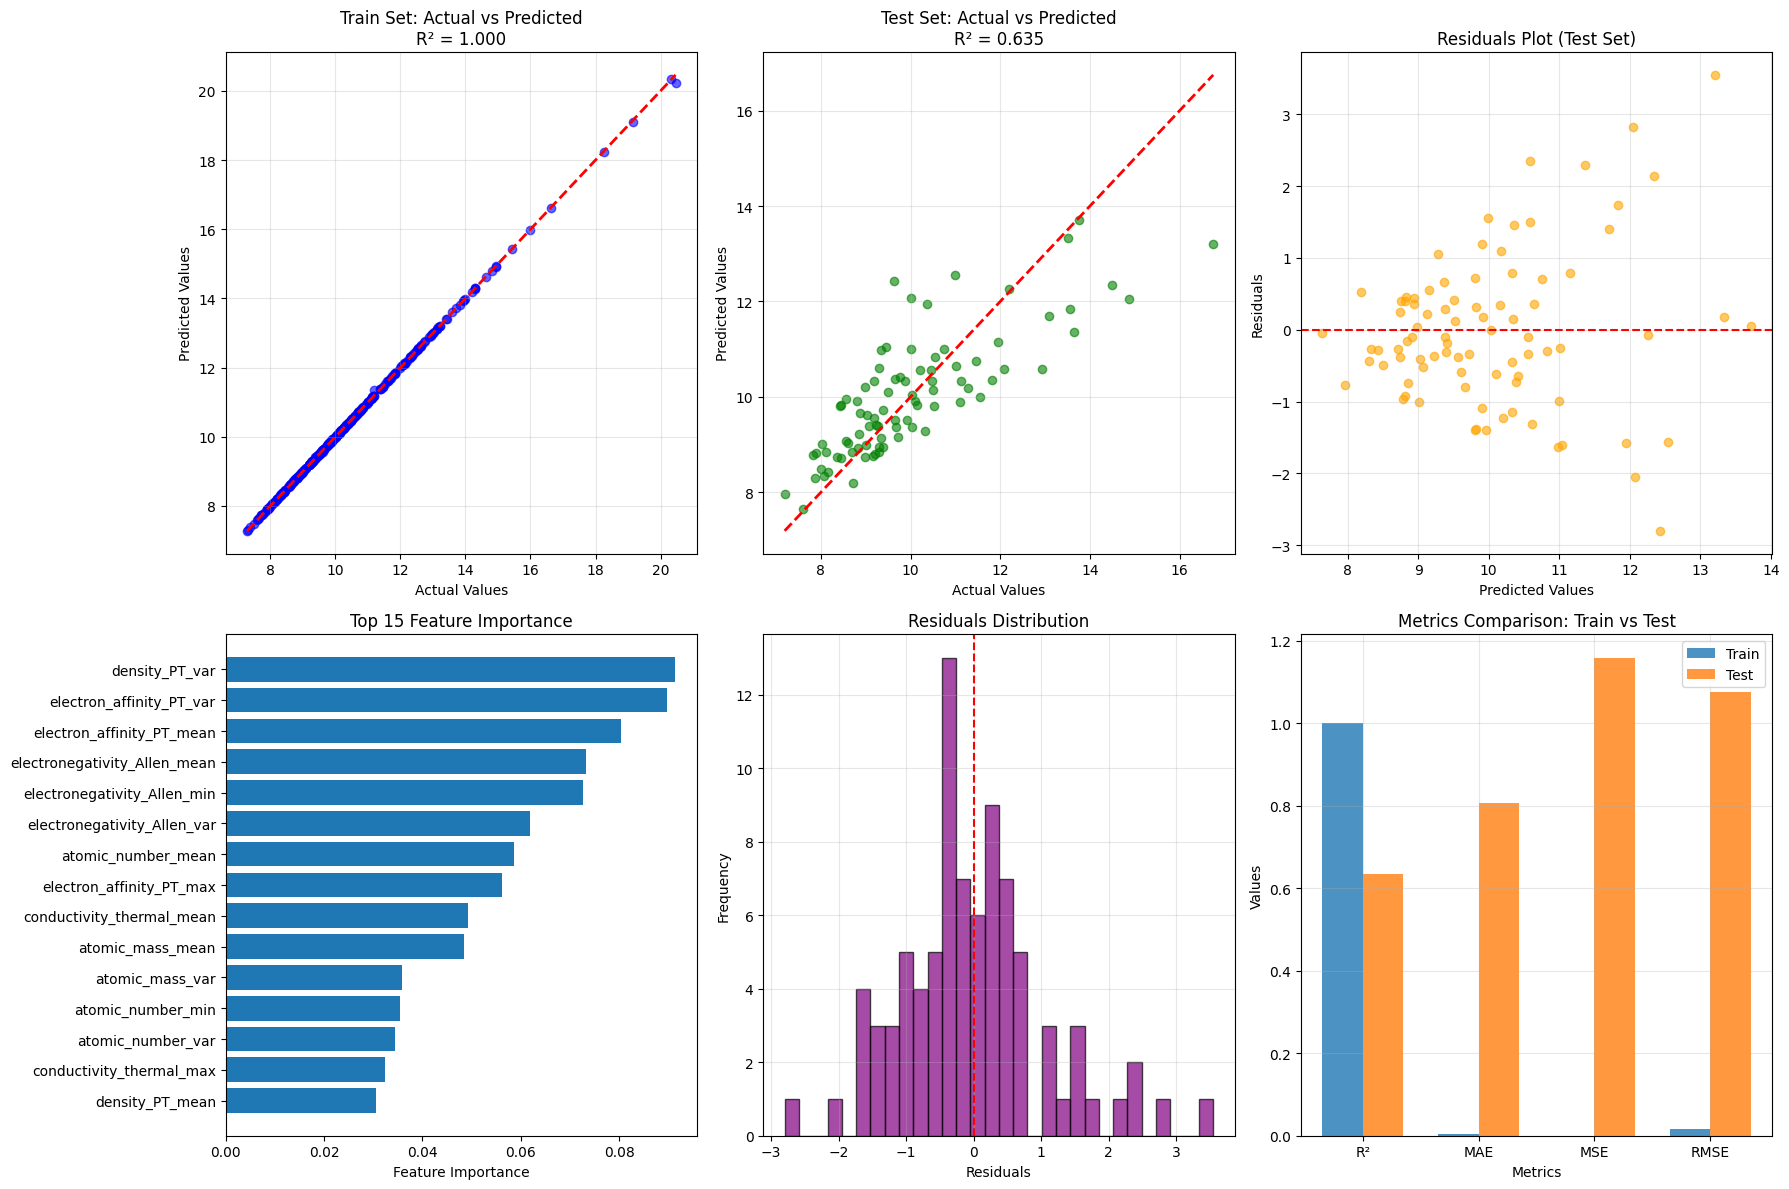


8. Model Performance Summary
Training Time: 0.26 seconds
Prediction Time: 0.01 seconds
Total Samples Processed: 427
Processing Speed: 1619 samples/second

Overfitting Analysis:
R² difference (Train - Test): 0.3651
⚠️  Potential overfitting detected

Random Forest regression analysis complete!


In [91]:
# Efficient Random Forest Regression Implementation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time
import pandas as pd

print("Efficient Random Forest Regression Analysis")
print("=" * 50)

# 1. Data Preparation
print("1. Data Preparation")
print(f"Dataset shape: {X.shape}, Target shape: {y.shape}")

# Train-test split for regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Target statistics:")
print(f"  Train - Mean: {np.mean(y_train):.3f}, Std: {np.std(y_train):.3f}")
print(f"  Test - Mean: {np.mean(y_test):.3f}, Std: {np.std(y_test):.3f}")

# 2. Random Forest Model Training
print(f"\n2. Random Forest Model Training")

# Optimized hyperparameters for efficiency and performance
rf_params = {
    'n_estimators': 100,        # Good balance of performance vs speed
    'max_depth': 15,           # Prevent overfitting
    'min_samples_split': 5,     # Ensure sufficient samples for splits
    'min_samples_leaf': 2,      # Prevent overfitting
    'max_features': 'sqrt',    # Random feature selection
    'random_state': 42        # Reproducibility
    #'n_jobs': -1              # Use all CPU cores
}

# Train Random Forest
start_time = time.time()
rf_model = GradientBoostingRegressor(**rf_params)
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")

# 3. Predictions
print(f"\n3. Making Predictions")
start_time = time.time()
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
prediction_time = time.time() - start_time

print(f"Predictions completed in {prediction_time:.2f} seconds")

# 4. Regression Metrics Calculation
def calculate_regression_metrics(y_true, y_pred, dataset_name):
    """Calculate comprehensive regression metrics"""

    # Basic metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # MAPE calculation (handle division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100

    # Additional metrics
    residuals = y_true - y_pred
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # Explained variance
    explained_variance = 1 - np.var(residuals) / np.var(y_true)

    metrics = {
        'R² Score': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'Mean Residual': mean_residual,
        'Std Residual': std_residual,
        'Explained Variance': explained_variance
    }

    print(f"\n{dataset_name} Metrics:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Mean Residual: {mean_residual:.4f}")
    print(f"  Std Residual: {std_residual:.4f}")
    print(f"  Explained Variance: {explained_variance:.4f}")

    return metrics

# Calculate metrics for both train and test sets
train_metrics = calculate_regression_metrics(y_train, y_train_pred, "Train Set")
test_metrics = calculate_regression_metrics(y_test, y_test_pred, "Test Set")

# 5. Cross-Validation
print(f"\n5. Cross-Validation Analysis")
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# 6. Feature Importance Analysis
print(f"\n6. Feature Importance Analysis")
feature_importance = rf_model.feature_importances_
feature_names = [f"{prop}_mean" for prop in prop_list] + \
                [f"{prop}_var" for prop in prop_list] + \
                [f"{prop}_min" for prop in prop_list] + \
                [f"{prop}_max" for prop in prop_list]

# Get top 10 most important features
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"Top 10 Most Important Features:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"  {i+1:2d}. {row['feature']:<20} {row['importance']:.4f}")

# 7. Comprehensive Visualization
print(f"\n7. Visualization and Analysis")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Actual vs Predicted (Train)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Train Set: Actual vs Predicted\nR² = {train_metrics["R² Score"]:.3f}')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted (Test)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R² Score"]:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals Plot (Test)
residuals = y_test - y_test_pred
axes[0, 2].scatter(y_test_pred, residuals, alpha=0.6, color='orange')
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Predicted Values')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Residuals Plot (Test Set)')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Feature Importance (Top 15)
top_features = importance_df.head(15)
axes[1, 0].barh(range(len(top_features)), top_features['importance'])
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].set_xlabel('Feature Importance')
axes[1, 0].set_title('Top 15 Feature Importance')
axes[1, 0].invert_yaxis()

# Plot 5: Residuals Distribution
axes[1, 1].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Metrics Comparison
metrics_names = ['R²', 'MAE', 'MSE', 'RMSE']
train_values = [train_metrics['R² Score'], train_metrics['MAE'],
                train_metrics['MSE'], train_metrics['RMSE']]
test_values = [test_metrics['R² Score'], test_metrics['MAE'],
               test_metrics['MSE'], test_metrics['RMSE']]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 2].bar(x - width/2, train_values, width, label='Train', alpha=0.8)
axes[1, 2].bar(x + width/2, test_values, width, label='Test', alpha=0.8)
axes[1, 2].set_xlabel('Metrics')
axes[1, 2].set_ylabel('Values')
axes[1, 2].set_title('Metrics Comparison: Train vs Test')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics_names)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Model Performance Summary
print(f"\n8. Model Performance Summary")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")
print(f"Total Samples Processed: {len(X_train) + len(X_test)}")
print(f"Processing Speed: {(len(X_train) + len(X_test)) / (training_time + prediction_time):.0f} samples/second")

print(f"\nOverfitting Analysis:")
overfitting_r2 = train_metrics['R² Score'] - test_metrics['R² Score']
print(f"R² difference (Train - Test): {overfitting_r2:.4f}")
if overfitting_r2 > 0.1:
    print("⚠️  Potential overfitting detected")
elif overfitting_r2 < 0.05:
    print("✅ Good generalization")
else:
    print("⚠️  Moderate overfitting")

print(f"\nRandom Forest regression analysis complete!")
